In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import linalg as LAS
import MaxLik as ML

Ideal HVDARL polaritazion states definition

In [2]:
H = np.array([[1],[0]])
V = np.array([[0],[1]])
D = 1/math.sqrt(2) * (H + V)
A = 1/math.sqrt(2) * (H - V)
R = 1/math.sqrt(2) * (H + 1j*V)
L = 1/math.sqrt(2) * (H - 1j*V)

idealStates = [H,V,D,A,R,L]
projList = ['H', 'V', 'D', 'A', 'R', 'L'] # List of projectors

# TNLC cell model
## Fitted parameters

In [3]:
a = -7.82057;
b = 0.0761821;
c = 176.156;
d = -2.89523;
e = -2.86832;
phi = -5.15607;
theta = -2.58144;

## Logistic function

In [4]:
retfun = lambda u_ : a + (1/(b + np.exp(d - c * (u_ ** e))))
# The prescription of the function describing the dependence of the ret. on applied voltage

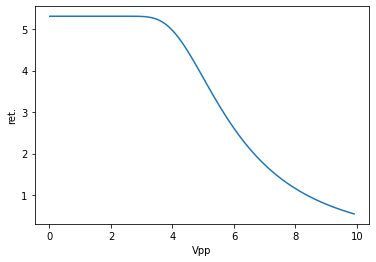

In [5]:
voltages = []
funcVal = []
for u in np.arange(0.01,10,0.1):
    voltages.append(u)
    funcVal.append(retfun(u))
    
plt.plot(voltages,funcVal)
plt.xlabel('Vpp')
plt.ylabel('ret.')
plt.show()

## TNLC cell matrix

In [6]:
lcmat = lambda u_: np.array([[np.cos(X(u_)) + (1j*gamma(u_) * np.sin(X(u_)))/X(u_), 
                            -((phi * np.sin(X(u_)))/X(u_))], 
                             [(phi * np.sin(X(u_)))/X(u_),
                            np.cos(X(u_)) - (1j * gamma(u_) * np.sin(X(u_))/X(u_))]])
gamma = lambda u_: retfun(u_)
X = lambda u_ : np.sqrt((phi**2) + gamma(u_)**2)
rot = lambda x_ : np.array([[np.cos(x_), np.sin(x_)], [-np.sin(x_), np.cos(x_)]])

### Resulting TNLC cell matrix

In [7]:
tnlcc = lambda u_ : rot(-theta)@rot(phi)@lcmat(u_)@rot(theta)

# TNLC cell polarization transformation
Output Johnes vector when H polarization impinges a single TN LCc where 10Vpp is applied.

In [8]:
print (np.matrix(tnlcc(10))@H) 

[[ 0.99538989-0.09132331j]
 [-0.02930242+0.00062192j]]


Output Johnes vector when H polarization impinges three TN LCc where on each one 10Vpp is applied.

In [9]:
print (np.matrix(tnlcc(10)@tnlcc(10)@tnlcc(10))@H) 

[[ 0.95876366-0.27060962j]
 [-0.08682904+0.00184288j]]


# Basic ideas of TNLCd tomography:

First, the TNLC device is calibrated to be able to prepare six particular polarization states (as close to H, V, D, A, R, and L polarization as possible). These states are accurately characterized. When an unknown polarization state impinges the TNLC device followed by a polarizer and a photodetector, the device performs a polarization projection to the particular state. Six detection responses are sequentially acquired for the corresponding calibrated states. The input polarization state could be easily retrieved by solving a set of resulting linear equations or, which is how we proceed, using the maximum-likelihood method.

## Import of conversions relations

In [10]:
def ReturnRho(jones): 
    '''
    Convert Jones vector to rho matrix
    '''
    return (jones@np.transpose(np.conjugate(jones)))

def Fidelity(rho1,rho2): 
    '''
    Returns fidelity between rho1 and rho2
    '''
    return ((np.trace(LAS.sqrtm(LAS.sqrtm(rho1)@rho2@LAS.sqrtm(rho1))))**2).real

### Sigma matrices

In [11]:
sigma1 = np.array([[1., 0.], [0., -1.]])
sigma2 = np.array([[0., 1.], [1., 0.]])
sigma3 = np.array([[0., -1j], [1j, 0.]])
sigma = np.array([sigma1, sigma2, sigma3])

### Convert rho matrix to Bloch vector

In [12]:
blochFromRho = lambda rho_ : np.real(np.array([
    np.trace(np.dot(rho_,sigma1)),
    np.trace(np.dot(rho_,sigma2)),
    np.trace(np.dot(rho_,sigma3))
]))

### Convert Bloch vector to rho matrix

In [13]:
rhoFromBloch = lambda bloch_ : np.array([
    [1+bloch_[0], bloch_[1]-1j*bloch_[2]],
    [bloch_[1]+1j*bloch_[2], 1-bloch_[0]]
])/2.

# Searching for target voltages
(grid sampling)

In [14]:
# preparation matrix of TNLCd 
TNLCd_prep = lambda u_: (tnlcc(u_[0])@tnlcc(u_[1])@tnlcc(u_[2])) 

In [15]:
# Output Bloch vector when H polarization impinges the TNLCd where on each cell 0.1Vpp is applied.
blochFromRho(ReturnRho(TNLCd_prep([.1,.1,.1])@H)) 

array([0.83347487, 0.52750096, 0.16450644])

In [16]:
# grid search for target voltages
voltageList = []
statesList = []
for u1 in np.arange(0.1,10,0.5):
    for u2 in np.arange(0.1,10,0.5):
        for u3 in np.arange(0.1,10,0.5):
            voltageList.append([u1,u2,u3])
            statesList.append(TNLCd_prep([u1,u2,u3])@H)
rhoLis = []
for state in statesList:
    rhoLis.append(ReturnRho(state))

In [17]:
print ('Fidelity of prepared states with the target ones')
voltages = []
for target in idealStates:
    fidelList = [Fidelity(rho,ReturnRho(target)) for rho in rhoLis]
    index = fidelList.index(max(fidelList))
    print(max(fidelList))
    #print(voltageList[index])
    voltages.append(voltageList[index])

Fidelity of prepared states with the target ones
0.9997787947973872
0.9974591303738243
0.9999010608034851
0.9996272525644051
0.9998496307903405
0.9999302003137419


In [18]:
# Generation of projectors correspondent with "best" voltages
def Proj(argument):
    return(TNLCd_prep(argument)@H)

projectors = []
for proj in projList:
    voltage = voltages[projList.index(proj)]
    projectors.append(np.outer(Proj(voltage),Proj(voltage).conj()))

# TNLCd Analysis

In [19]:
# analyzed state - |IN>
inState = L

# number of photons used for analysis
photons = 100000

In [20]:
linPol = np.array([[1,0],[0,0]])

# Analysis matrix of TNLCd
TNLCd_anal = lambda u_: (tnlcc(u_[2])@tnlcc(u_[1])@tnlcc(u_[0])) 

def OutState(argument):
    return(linPol@TNLCd_anal(argument)@inState)

#### Polarization state measurement - simulation

In [21]:
# probabilities of each projection measurement when the input polarization state is analyzed
data = []
for proj in projList:
    outState = OutState(voltages[projList.index(proj)])
    data.append(abs(np.transpose(outState)@outState)[0][0])

prob = data/sum(data)
countData = np.random.multinomial(photons,prob) #photons per projection - all projections measured at the same time (model)

print ('Photons per proj.: ' + str(countData))

Photons per proj.: [17039 18167 16008 15653    11 33122]


## Maximum-likelihood

State reconstruction using MaxLik

In [22]:
[rho,bloch] = ML.Maxlik(countData, projectors)

# Result

In [23]:
print ('Analyzed state: ' + str(bloch))
print ('|IN>:           ' + str(blochFromRho(ReturnRho(inState))))

Analyzed state: [ 0.02475985 -0.00738292 -0.99966617]
|IN>:           [ 0.  0. -1.]
